# Detecting Pediatric Pneumonia in Chest X-Rays Using Convolutional Neural Networks

## Overview

This project uses Convolutional Neural Network (CNN) models to diagnose pediatric pneumonia by classifying chest X-rays of patients. Pneumonia poses a major health risk to children so the need for timely treatment and intervention is critical. The model could be used to provide a 'second' opinion to doctors in diagnosing pneumonia. We produced a CNN with 86% diagnosis accuracy with high sensitivty to pneumonia, correctly identifying 98% of penumonia-positive patients in the testing data. 

## Business Understanding

Pneumonia is responsible for more childhood deaths than any other infectious disease worldwide, and early diagnosis and treatment are critical for short-term and long-term health outcomes for patients. We are given the task of using X-Ray data from pediatric patients to create a model that can assist medical professionals in diagnosing and evaluating chest X-rays. Correctly identifying and diagnosing pneumonia and beginning treatment sooner can lead to faster recovery and better patient results. Providing a “second opinion” to medical professionals after initial diagnosis can help prevent patients from being misdiagnosed and untreated.

## Data Understanding

We used a dataset of pediatric chest X-ray images downloaded from Kaggle. These anterior-posterior chest X-ray images were collected from Guangzhou Women and Children's Medical Center, Guangzhou. The patients ranged from one to five years old with X-ray imaging performed during routine clinical care. The pneumonia X-ray images contained examples of bacterial and viral pneumonia.

Due to the size of the dataset, we did not upload the data to this project's GitHub repository. The dataset can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

The data was downloaded as a zipped folder "chest_xray", in which there were 3 folders "test", "train", and "val". Each of these 3 folders contained 2 subfolders for the image categories "PNEUMONIA" and "NORMAL". In total, there were 5,863 X-Ray images (JPEG). 

One limitation of this data was the low number of images in the 'val' folder. There are only 16 images in 'val' which was not enough to provide a proper validation or test set.

### Data Preparation

We prepared our data for a binary classification problem using Convolutional Neural Networks (CNNs) to predict the class of chest X-ray images.

The "val" folder contained only 16 X-ray images: 8 for normal and 8 for pneumonia. Since the size of this data subset was too small to use in our model validation process, we chose to split a portion of the training data into a validation set. The images in the "test" folder were used as our final holdout test set to evaluate our model's performance on unseen data. 

In [132]:
#import statements
import numpy as np
import os, tempfile
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import pickle

In [2]:
#load in the train data
#"chest_xray" folder was placed in a separate 'data' directory within local repositories

train_normal_dir = "./data/chest_xray/train/NORMAL"
train_pneumonia_dir = "./data/chest_xray/train/PNEUMONIA"

#from the subfolders, extract a list of all jpeg files
#separate X-rays by category: normal and pneumonia
imgs_train_normal = [file for file in os.listdir(train_normal_dir) if file.endswith('.jpeg')]
imgs_train_pneumonia = [file for file in os.listdir(train_pneumonia_dir) if file.endswith('.jpeg')]

In [3]:
#load in the train data
test_normal_dir = "./data/chest_xray/test/NORMAL"
test_pneumonia_dir = "./data/chest_xray/test/PNEUMONIA"

#from the subfolders, extract a list of all jpeg files
#separate X-rays by category: normal and pneumonia
imgs_test_normal = [file for file in os.listdir(test_normal_dir) if file.endswith('.jpeg')]
imgs_test_pneumonia = [file for file in os.listdir(test_pneumonia_dir) if file.endswith('.jpeg')]

In [4]:
print(f'Training set: there are {len(imgs_train_normal)} normal images and {len(imgs_train_pneumonia)} pneumonia images.')
print(f'Test set: there are {len(imgs_test_normal)} normal images and {len(imgs_test_pneumonia)} pneumonia images.')

Training set: there are 1341 normal images and 3875 pneumonia images.
Test set: there are 234 normal images and 390 pneumonia images.


In [5]:
#breakdown of the class distributions for training and test sets
num_train = len(imgs_train_normal) + len(imgs_train_pneumonia)
num_test = len(imgs_test_normal) + len(imgs_test_pneumonia)
train_percent_pneumonia = round( (len(imgs_train_pneumonia)/num_train) * 100, 1)
test_percent_pneumonia = round( (len(imgs_test_pneumonia)/num_test) * 100, 1)

print(f'The training set has {num_train} images, {train_percent_pneumonia}% of which are categorized as pneumonia.')
print(f'The test set has {num_test} images, {test_percent_pneumonia}% of which are categorized as pneumonia.')

The training set has 5216 images, 74.3% of which are categorized as pneumonia.
The test set has 624 images, 62.5% of which are categorized as pneumonia.


We used ImageDataGenerator from Keras to process our jpeg images into tensors to feed into our neural network models. The images were rescaled to 64 x 64 size, with 20% of the training set separated into a validation set. We also performed data augmentation to provide our model with varied images to improve performance on unseen data. 

In [6]:
#create image data generator for train data
#80% train/20% validation split 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   validation_split=0.2)

In [7]:
#rescale images to 64 by 64
#create validation set as 20% of train set
#random seed set for reproducibility in validation split

train_folder = "./data/chest_xray/train"
train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train, seed=42)

validation_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(64, 64), 
        color_mode='grayscale', 
        class_mode='binary',
        subset='validation',
        batch_size= num_train, seed=42)

test_folder = "./data/chest_xray/test"
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), color_mode='grayscale', 
        class_mode='binary', 
        batch_size= num_test)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
#create images and labels arrays from DirectoryIterator objects
train_images, train_labels = next(train_gen)
val_images, val_labels = next(validation_gen)
test_images, test_labels = next(test_gen)

In [9]:
#sum should match number of pneumonia cases in the pre-split training set
#indicates that class 1 = pneumonia
sum(train_labels) + sum(val_labels)

3875.0

Our class labels were 0 corresponding with 'normal' and 1 corresponding with 'pneumonia'.

In [10]:
#training images at their original resolution (256x256)
train_folder = "./data/chest_xray/train"
train_unaltered = train_datagen.flow_from_directory(
        train_folder, 
        color_mode='grayscale', 
        class_mode='binary',
        subset='training',
        batch_size= num_train,
        seed=42)

Found 4173 images belonging to 2 classes.


In [11]:
unaltered_images, unaltered_labels = next(train_unaltered)

Here's an X-ray from the training data in its scaled down resolution (64 x 64) and in its original resolution (256 x 256):

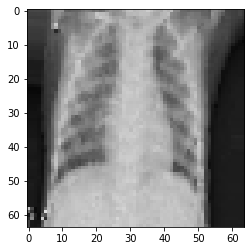

In [12]:
plt.imshow(train_images[0], cmap='gray', vmin=0, vmax=1);

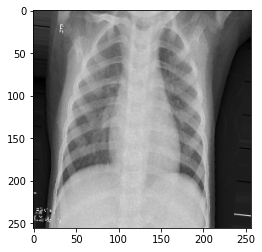

In [13]:
plt.imshow(unaltered_images[0], cmap='gray', vmin=0, vmax=1);

In [14]:
#( number of images, image height, image wideth, color channel(s) )
print(f'train: {train_images.shape}')
print(f'val: {val_images.shape}')
print(f'test: {test_images.shape}')

train: (4173, 64, 64, 1)
val: (1043, 64, 64, 1)
test: (624, 64, 64, 1)


In [15]:
#confirm correct shape for labels
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4173,)
(1043,)
(624,)


We also reshaped our features and labels to be passed into dense layers in our CNN models.

In [16]:
#reshaping features for dense layers
train_reshape = train_images.reshape(train_images.shape[0], -1)
val_reshape = val_images.reshape(val_images.shape[0], -1)
test_reshape = test_images.reshape(test_images.shape[0], -1)

train_y = np.reshape(train_labels, (4173,1))
val_y = np.reshape(val_labels, (1043,1))
test_y = np.reshape(test_labels, (624,1))

print('Reshaped images:')
print(train_reshape.shape)
print(val_reshape.shape)
print(test_reshape.shape)

print('\nReshaped labels:')
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

Reshaped images:
(4173, 4096)
(1043, 4096)
(624, 4096)

Reshaped labels:
(4173, 1)
(1043, 1)
(624, 1)


We've accomplished the following with our data preparation:
* Transformed image data into tensors
* Performed data augmentation for our training data
* Split 20% of our training data into a validation set
* Prepared a holdout test set for final model evaluation
* Reshaped data into the right shapes for our CNN layers

## Modeling

The metrics we used in evaluating our model were accuracy and recall. Accuracy was important as a measure of our model's ability to correctly diagnose a patient based on their X-ray. Recall represented the model's sensitivity to the pneumonia class. Our model was designed to provide a second opinion on X-rays to ensure that patients with pneumonia are detected. We wanted our model to provide a red flag for when a doctor might have overlooked signs of pneumonia in the X-rays. Therefore, we wanted to minimize false-negative rate, meaning recall was a critical metric in determining our best model.

In [17]:
#helper function to store metrics in a dictionary format for easy recall
def metrics_to_dict(model_name, metrics, metrics_dict):
    '''
    Returns a dictionary with model name as key and dictionaries of metrics
    as values.
    Nested dictionary has metric names as keys and the scores as values.
    
    Takes the following arguments:
    model_name: String of model name
    metrics: list of metric scores from model.evaluate(), must match metric_names
    metrics_dict: dictionary to be added to
    '''
    metrics_dict[model_name]={}
    metric_names = ['loss', 'accuracy', 'recall']
    for i,metric in enumerate(metric_names):
        metrics_dict[model_name][metric] = metrics[i]
    return metrics_dict

In [18]:
#initialize an empty metrics dictionary
metrics_dict = {}

### Dummy Classifier

We used sklearn's DummyClassifier to establish a baseline for model performance. This DummyClassifier predicts the majority class (pneumonia) for every instance and has an accuracy of 74.3% and a recall of 1.0.

In [19]:
dummy_clf = DummyClassifier()
dummy_clf.fit(train_images, train_labels)
dummy_clf.score(train_images, train_labels)

0.7428708363287803

In [20]:
dummy_clf.score(val_images, val_labels)

0.7430488974113135

### Dense Neural Network

Our first modeling iteration was a neural network with several dense layers. This was created to give us a comparison to CNN models which are generally better suited for image recognition tasks.

In [55]:
dense_model = models.Sequential()
dense_model.add(layers.Dense(20, activation='relu', input_shape=(4096,)))
dense_model.add(layers.Dense(7, activation='relu'))
dense_model.add(layers.Dense(5, activation='relu'))
dense_model.add(layers.Dense(1, activation='sigmoid'))

dense_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20)                81940     
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 82,133
Trainable params: 82,133
Non-trainable params: 0
_________________________________________________________________


In [56]:
dense_model.compile(optimizer='sgd', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy', tf.keras.metrics.Recall()])

In [57]:
dense_model.fit(train_reshape, 
                train_y, 
                epochs=30, 
                batch_size=50, 
                validation_data=(val_reshape, val_y))

Epoch 1/30
84/84 [==============================] - 2s 12ms/step - loss: 0.5509 - accuracy: 0.7429 - recall_6: 1.0000 - val_loss: 0.5100 - val_accuracy: 0.7430 - val_recall_6: 1.0000
Epoch 2/30
84/84 [==============================] - 1s 9ms/step - loss: 0.4970 - accuracy: 0.7434 - recall_6: 1.0000 - val_loss: 0.4799 - val_accuracy: 0.7430 - val_recall_6: 1.0000
Epoch 3/30
84/84 [==============================] - 1s 9ms/step - loss: 0.4473 - accuracy: 0.7577 - recall_6: 0.9981 - val_loss: 0.4375 - val_accuracy: 0.7584 - val_recall_6: 0.9987
Epoch 4/30
84/84 [==============================] - 1s 6ms/step - loss: 0.4284 - accuracy: 0.8057 - recall_6: 0.9481 - val_loss: 0.5417 - val_accuracy: 0.7277 - val_recall_6: 0.6697
Epoch 5/30
84/84 [==============================] - 1s 9ms/step - loss: 0.4051 - accuracy: 0.8248 - recall_6: 0.9290 - val_loss: 0.3596 - val_accuracy: 0.8485 - val_recall_6: 0.9265
Epoch 6/30
84/84 [==============================] - 1s 6ms/step - loss: 0.3893 - accuracy

In [58]:
dense_train = dense_model.evaluate(train_reshape, train_y)
dense_train

131/131 [==============================] - 1s 8ms/step - loss: 0.2233 - accuracy: 0.9073 - recall_6: 0.9487


[0.223294198513031, 0.9072609543800354, 0.9487096667289734]

In [59]:
dense_val = dense_model.evaluate(val_reshape, val_y)
dense_val

33/33 [==============================] - 0s 6ms/step - loss: 0.2784 - accuracy: 0.8734 - recall_6: 0.9187


[0.27844637632369995, 0.8734419941902161, 0.9187096953392029]

Our first model, a neural network of dense layers, performed better on the training set than on the validation set for both accuracy and recall. There was about a 3% difference in both accuracy and recall between training metrics and validation metrics.

This model had better accuracy than the Dummy Classifier with 87% accuracy on the validation data, a 13% increase in accuracy versus the Dummy Classifier. Recall on the validation data was 91%. The Dummy Classifier had a recall of 100% since it predicts pneumonia for every image. Our model evaluations during our iterative process were based on the tradeoff between increasing accuracy without sacrificing performance in recall.

### CNNs

CNNs are a type of neural network that perform well on computer vision problems. The convolution layers of CNNs apply a transformation filter to the image matrix to reduce portions of the image matrix into values capturing information of nearby areas of the image. Pooling layers reduce dimensionality with MaxPooling replacing n x n blocks of the matrix with the largest value in each block.

In [63]:
#setting up a simple convolutional model
simple_cnn = models.Sequential()

#model with 2 convolutional layers + 1 pooling layer
simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))
simple_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))
simple_cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
          input_shape=(64, 64, 1)))

#single dense layer
simple_cnn.add(layers.Flatten())
simple_cnn.add(layers.Dense(64, activation='relu'))

#output layer
simple_cnn.add(layers.Dense(1, activation='sigmoid'))

simple_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                3444800   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 3,482,433
Trainable params: 3,482,433
Non-trainable params: 0
____________________________________________

In [64]:
simple_cnn.compile(optimizer='sgd', 
                   loss='binary_crossentropy', 
                   metrics=['accuracy', tf.keras.metrics.Recall()])

In [65]:
simple_cnn.fit(train_images, 
               train_labels, 
               epochs=30, 
               batch_size=50, 
               validation_data=(val_images, val_labels))

Epoch 1/30
84/84 [==============================] - 10s 117ms/step - loss: 0.5654 - accuracy: 0.7429 - recall_8: 1.0000 - val_loss: 0.5372 - val_accuracy: 0.7430 - val_recall_8: 1.0000
Epoch 2/30
84/84 [==============================] - 10s 115ms/step - loss: 0.5092 - accuracy: 0.7549 - recall_8: 0.9971 - val_loss: 0.4707 - val_accuracy: 0.7459 - val_recall_8: 1.0000
Epoch 3/30
84/84 [==============================] - 10s 115ms/step - loss: 0.4527 - accuracy: 0.8013 - recall_8: 0.9552 - val_loss: 0.3897 - val_accuracy: 0.8543 - val_recall_8: 0.9497
Epoch 4/30
84/84 [==============================] - 10s 115ms/step - loss: 0.3807 - accuracy: 0.8380 - recall_8: 0.9432 - val_loss: 0.3670 - val_accuracy: 0.8255 - val_recall_8: 0.9832
Epoch 5/30
84/84 [==============================] - 10s 114ms/step - loss: 0.3383 - accuracy: 0.8543 - recall_8: 0.9355 - val_loss: 0.3351 - val_accuracy: 0.8581 - val_recall_8: 0.8955
Epoch 6/30
84/84 [==============================] - 10s 114ms/step - loss: 

In [66]:
simple_cnn_train = simple_cnn.evaluate(train_images, train_labels)
simple_cnn_train

131/131 [==============================] - 2s 15ms/step - loss: 0.1921 - accuracy: 0.9221 - recall_8: 0.9532


[0.19208413362503052, 0.9221183657646179, 0.9532257914543152]

In [67]:
simple_cnn_val = simple_cnn.evaluate(val_images, val_labels)
simple_cnn_val

33/33 [==============================] - 0s 13ms/step - loss: 0.2532 - accuracy: 0.8926 - recall_8: 0.9252


[0.2531707286834717, 0.8926174640655518, 0.9251613020896912]

In [68]:
metrics_dict = {}

In [69]:
#saving validation scores to dictionary
metrics_to_dict('Simple CNN', simple_cnn_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912}}

This first CNN model had better accuracy and recall scores on the training data, suggesting some overfitting was occurring.

Compared to the dense model, the CNN model improved on both accuracy and recall. Accuracy was higher by ~2% and recall saw a slight increase of about 0.7% on the validation data. Given the improved accuracy scores and the comparable recall scores, we concluded that this first CNN model was an improvement over our initial dense layer model and decided to iterate upon this CNN model.

### Iterating on CNN Models

Our first CNN model had better accuracy than the dummy model and slightly better than the dense model. We added more convolutional layers for our next model to increase model complexity and improve accuracy.

The first CNN model also showed signs of overfitting. We employed several techniques in our modeling iterations to attempt to address this. Our first technique was adding a dropout layer before the dense layer of the CNN. We also added early stopping to prevent our model from continuing to train if there was no reduction in validation error after a certain number of epochs.

In [19]:
#EarlyStopping object to add to callbacks parameter in .fit
#if there is no reduction in val_loss of at least 0.01 by 8 epochs, stop the fit
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=8, mode = 'min')

In [22]:
cnn_2 = models.Sequential()

#3 pairs of convolutional and pooling layers
#filter size changed to 2,2
cnn_2.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu', 
          input_shape=(64, 64, 1)))
cnn_2.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_2.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
cnn_2.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_2.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
cnn_2.add(layers.MaxPooling2D(pool_size=(2,2)))

#single dense layer
#one dropout layer
cnn_2.add(layers.Flatten())
cnn_2.add(layers.Dropout(0.5))
cnn_2.add(layers.Dense(64, activation='relu'))

#output layer
cnn_2.add(layers.Dense(1, activation='sigmoid'))
cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 63, 63, 32)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       32896     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [23]:
cnn_2.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [24]:
cnn_2.fit(train_images, 
          train_labels, 
          epochs=20, 
          batch_size=30, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/20
140/140 [==============================] - 10s 67ms/step - loss: 0.4907 - accuracy: 0.7441 - recall: 0.9910 - val_loss: 0.3523 - val_accuracy: 0.8600 - val_recall: 0.9729
Epoch 2/20
140/140 [==============================] - 15s 107ms/step - loss: 0.3306 - accuracy: 0.8639 - recall: 0.9748 - val_loss: 0.3211 - val_accuracy: 0.8696 - val_recall: 0.9781
Epoch 3/20
140/140 [==============================] - 16s 112ms/step - loss: 0.3017 - accuracy: 0.8905 - recall: 0.9552 - val_loss: 0.3302 - val_accuracy: 0.8706 - val_recall: 0.8426
Epoch 4/20
140/140 [==============================] - 15s 110ms/step - loss: 0.2694 - accuracy: 0.9070 - recall: 0.9526 - val_loss: 0.2382 - val_accuracy: 0.8965 - val_recall: 0.8916
Epoch 5/20
140/140 [==============================] - 15s 110ms/step - loss: 0.1931 - accuracy: 0.9216 - recall: 0.9487 - val_loss: 0.1890 - val_accuracy: 0.9214 - val_recall: 0.9200
Epoch 6/20
140/140 [==============================] - 16s 111ms/step - loss: 0.1783 - 

In [25]:
cnn_2.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 7ms/step - loss: 0.0917 - accuracy: 0.9710 - recall: 0.9719


[0.09174741804599762, 0.971004068851471, 0.971935510635376]

In [175]:
cnn_2_val = cnn_2.evaluate(val_images, val_labels)
cnn_2_val

33/33 [==============================] - 0s 7ms/step - loss: 0.1735 - accuracy: 0.9329 - recall: 0.9355


[0.1734742373228073, 0.9328858852386475, 0.9354838728904724]

In [71]:
#saving validation scores to dictionary
metrics_to_dict('CNN_2', cnn_2_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724}}

This second CNN model demonstrated improved accuracy and recall scores compared to previous models. Training metrics were 4% higher than validation metrics, indicating our model was overfit to the training data.

#### Adding Padding and Adjusting Solver

Our next model included padding in the convolutional layers. This adds additional pixels bordering the images so that a filter can evenly pass over the image without losing information at the edges. With padding, we readjusted the convolutional layer filter sizes. Additionally, the solver in the compiler was changed from 'sgd' to 'adam'. The 'sgd' solver was getting stuck during gradient descent with weights yielding 74.29% accuracy on the training set and a recall of 1.0 (matching the dummy classifier). Switching the solver allowed us to run these models in a more timely manner and continue our modeling iteraitons.

In [52]:
cnn_3 = models.Sequential()

#3 pairs of convolutional and pooling layers
#filter size changed to 3,3 with padding of 1
cnn_3.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
cnn_3.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_3.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
cnn_3.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_3.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
cnn_3.add(layers.MaxPooling2D(pool_size=(2,2)))

#two dense layers
#one dropout layer
cnn_3.add(layers.Flatten())
cnn_3.add(layers.Dense(64, activation='relu'))
cnn_3.add(layers.Dropout(0.5))
cnn_3.add(layers.Dense(64, activation='relu'))

#output layer
cnn_3.add(layers.Dense(1, activation='sigmoid'))

cnn_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)            

In [53]:
cnn_3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [54]:
cnn_3.fit(train_images, 
          train_labels, 
          epochs=20, 
          batch_size=100, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/20
42/42 [==============================] - 7s 143ms/step - loss: 0.5993 - accuracy: 0.7376 - recall_8: 0.9884 - val_loss: 0.5826 - val_accuracy: 0.7430 - val_recall_8: 1.0000
Epoch 2/20
42/42 [==============================] - 6s 138ms/step - loss: 0.5075 - accuracy: 0.7455 - recall_8: 0.9958 - val_loss: 0.4620 - val_accuracy: 0.7450 - val_recall_8: 1.0000
Epoch 3/20
42/42 [==============================] - 6s 139ms/step - loss: 0.3634 - accuracy: 0.7961 - recall_8: 0.9510 - val_loss: 0.3249 - val_accuracy: 0.8418 - val_recall_8: 0.8155
Epoch 4/20
42/42 [==============================] - 6s 140ms/step - loss: 0.3108 - accuracy: 0.8514 - recall_8: 0.9484 - val_loss: 0.2792 - val_accuracy: 0.8917 - val_recall_8: 0.9174
Epoch 5/20
42/42 [==============================] - 6s 139ms/step - loss: 0.2591 - accuracy: 0.8979 - recall_8: 0.9481 - val_loss: 0.2450 - val_accuracy: 0.9060 - val_recall_8: 0.9329
Epoch 6/20
42/42 [==============================] - 6s 137ms/step - loss: 0.2428

In [55]:
cnn_3.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 7ms/step - loss: 0.0840 - accuracy: 0.9727 - recall_8: 0.9884


[0.08403049409389496, 0.9726815223693848, 0.9883871078491211]

In [177]:
cnn_3_val = cnn_3.evaluate(val_images, val_labels)
cnn_3_val

33/33 [==============================] - 0s 7ms/step - loss: 0.1740 - accuracy: 0.9386 - recall_8: 0.9652


[0.1739967167377472, 0.9386385679244995, 0.9651612639427185]

In [73]:
#saving validation scores to dictionary
metrics_to_dict('CNN_3', cnn_3_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724},
 'CNN_3': {'loss': 0.1739967167377472,
  'accuracy': 0.9386385679244995,
  'recall': 0.9651612639427185}}

This third CNN model had comparable accuracy scores (97.3% train, 93.9% validation) to those of the previous model (97.1% train, 93.3% validation). However, the recall scores for this third model were improved at 0.988 for train and 0.965 for validation. 

So far with our CNN iterations, we've improved the metrics on our validation set: accuracy from 89% to 94% and recall from 93% to 97%. Overfitting was our main concern as we were getting seeing a consistent decrease in our metrics between training and validation evalutations.

#### Adding L2 Regularization

Dropout was one technique to address overfitting. We also added L2 regularization to our convolution layers to see if that could reduce the overfitting. We tried applying different strengths of L2 regularization. 

In [67]:
cnn_4 = models.Sequential()

#3 pairs of convolutional and pooling layers
#filter size changed to 3,3 with padding of 1
#added L2 regularization to two convolutional layers with l2 = 0.01
cnn_4.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
cnn_4.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_4.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer= l2(l=0.01)))
cnn_4.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_4.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer= l2(l=0.01)))
cnn_4.add(layers.MaxPooling2D(pool_size=(2,2)))

#two dense layers
#one dropout layer
cnn_4.add(layers.Flatten())
cnn_4.add(layers.Dense(64, activation='relu'))
cnn_4.add(layers.Dropout(0.5))
cnn_4.add(layers.Dense(64, activation='relu'))

#output layer
cnn_4.add(layers.Dense(1, activation='sigmoid'))

cnn_4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)            

In [68]:
cnn_4.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [69]:
cnn_4.fit(train_images, 
          train_labels, 
          epochs=20, 
          batch_size=30, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/20
140/140 [==============================] - 16s 112ms/step - loss: 0.8092 - accuracy: 0.7366 - recall_11: 0.9874 - val_loss: 0.5932 - val_accuracy: 0.7430 - val_recall_11: 1.0000
Epoch 2/20
140/140 [==============================] - 18s 131ms/step - loss: 0.5872 - accuracy: 0.7429 - recall_11: 1.0000 - val_loss: 0.5526 - val_accuracy: 0.7430 - val_recall_11: 1.0000
Epoch 3/20
140/140 [==============================] - 18s 130ms/step - loss: 0.5096 - accuracy: 0.7481 - recall_11: 0.9848 - val_loss: 0.5676 - val_accuracy: 0.6683 - val_recall_11: 0.6181
Epoch 4/20
140/140 [==============================] - 18s 129ms/step - loss: 0.4067 - accuracy: 0.8229 - recall_11: 0.9235 - val_loss: 0.3343 - val_accuracy: 0.8639 - val_recall_11: 0.9045
Epoch 5/20
140/140 [==============================] - 18s 127ms/step - loss: 0.3299 - accuracy: 0.8689 - recall_11: 0.9284 - val_loss: 0.3436 - val_accuracy: 0.8629 - val_recall_11: 0.9406
Epoch 6/20
140/140 [==============================] - 1

In [70]:
cnn_4.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 10ms/step - loss: 0.1633 - accuracy: 0.9490 - recall_11: 0.9816


[0.16333961486816406, 0.9489575624465942, 0.9816129207611084]

In [71]:
cnn_4_val = cnn_4.evaluate(val_images, val_labels)
cnn_4_val

33/33 [==============================] - 0s 6ms/step - loss: 0.2040 - accuracy: 0.9310 - recall_11: 0.9690


[0.2040490359067917, 0.9309683442115784, 0.9690322875976562]

In [75]:
#saving validation scores to dictionary
metrics_to_dict('CNN_4', cnn_4_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724},
 'CNN_3': {'loss': 0.1739967167377472,
  'accuracy': 0.9386385679244995,
  'recall': 0.9651612639427185},
 'CNN_4': {'loss': 0.2040490359067917,
  'accuracy': 0.9309683442115784,
  'recall': 0.9690322875976562}}

With L2 regularization of 0.1, the model appeared to be less overfit at the cost of some accuracy. The difference between train and validation accuracy was 1.8%, compared to a difference of 3.4% in the previous model (cnn_3). Recall scores were very close between the model with regularization and the model without regularization. 

In [ ]:
#cnn_4.save('saved_models/cnn_4')

#### Adjusting Regularization Strength

We also tested a model with the same layer structure except with L2 regularization of 0.001, a larger penalty.

In [72]:
cnn_5 = models.Sequential()

#3 pairs of convolutional and pooling layers
#filter size changed to 3,3 with padding of 1
#added L2 regularization to two convolutional layers with l2 = 0.001
cnn_5.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
cnn_5.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_5.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer= l2(l=0.001)))
cnn_5.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_5.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer= l2(l=0.001)))
cnn_5.add(layers.MaxPooling2D(pool_size=(2,2)))

#two dense layers
#one dropout layer
cnn_5.add(layers.Flatten())
cnn_5.add(layers.Dense(64, activation='relu'))
cnn_5.add(layers.Dropout(0.5))
cnn_5.add(layers.Dense(64, activation='relu'))

#output layer
cnn_5.add(layers.Dense(1, activation='sigmoid'))

cnn_5.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 4096)            

In [73]:
cnn_5.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [74]:
cnn_5.fit(train_images, 
          train_labels, 
          epochs=20, 
          batch_size=30, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/20
140/140 [==============================] - 16s 111ms/step - loss: 0.5682 - accuracy: 0.7584 - recall_12: 0.9761 - val_loss: 0.3436 - val_accuracy: 0.8581 - val_recall_12: 0.9187
Epoch 2/20
140/140 [==============================] - 8s 57ms/step - loss: 0.3546 - accuracy: 0.8548 - recall_12: 0.9161 - val_loss: 0.3827 - val_accuracy: 0.8351 - val_recall_12: 0.9871
Epoch 3/20
140/140 [==============================] - 11s 76ms/step - loss: 0.3024 - accuracy: 0.8845 - recall_12: 0.9332 - val_loss: 0.2961 - val_accuracy: 0.8840 - val_recall_12: 0.8852
Epoch 4/20
140/140 [==============================] - 10s 72ms/step - loss: 0.2565 - accuracy: 0.9041 - recall_12: 0.9365 - val_loss: 0.2817 - val_accuracy: 0.9003 - val_recall_12: 0.8994
Epoch 5/20
140/140 [==============================] - 10s 72ms/step - loss: 0.2343 - accuracy: 0.9202 - recall_12: 0.9442 - val_loss: 0.2700 - val_accuracy: 0.9070 - val_recall_12: 0.9652
Epoch 6/20
140/140 [==============================] - 12s 89

In [75]:
cnn_5.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 10ms/step - loss: 0.0988 - accuracy: 0.9739 - recall_12: 0.9832


[0.0987720713019371, 0.9738796949386597, 0.9832258224487305]

In [185]:
cnn_5_val = cnn_5.evaluate(val_images, val_labels)
cnn_5_val

33/33 [==============================] - 0s 9ms/step - loss: 0.1951 - accuracy: 0.9434 - recall_12: 0.9587


[0.19512240588665009, 0.9434323906898499, 0.9587096571922302]

In [77]:
#saving validation scores to dictionary
metrics_to_dict('CNN_5', cnn_5_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724},
 'CNN_3': {'loss': 0.1739967167377472,
  'accuracy': 0.9386385679244995,
  'recall': 0.9651612639427185},
 'CNN_4': {'loss': 0.2040490359067917,
  'accuracy': 0.9309683442115784,
  'recall': 0.9690322875976562},
 'CNN_5': {'loss': 0.19512240588665009,
  'accuracy': 0.9434323906898499,
  'recall': 0.9587096571922302}}

For this model with L2 regularization of 0.001, the difference in accuracy between train and validation was 3%. Adding this level of regularization did not improve overfitting compared against models with no regularization. 

#### Revisiting Previous Model with more Epochs

With regularization and dropout, we managed to reduce overfitting in one of our models at the cost of some accuracy. We tried running the regularized model with more epochs to see if we could increase model accuracy without re-introducing overfitting. Training the model for additional epochs could diminish the overfitting reduction from regularization.

In [102]:
#running cnn_4 (L2 regularization = 0.1) for 10 additional epochs
cnn_4.fit(train_images, 
          train_labels, 
          epochs=10, 
          batch_size=30, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/10
140/140 [==============================] - 16s 112ms/step - loss: 0.1914 - accuracy: 0.9396 - recall_11: 0.9594 - val_loss: 0.2173 - val_accuracy: 0.9223 - val_recall_11: 0.9252
Epoch 2/10
140/140 [==============================] - 16s 112ms/step - loss: 0.1827 - accuracy: 0.9425 - recall_11: 0.9616 - val_loss: 0.1959 - val_accuracy: 0.9329 - val_recall_11: 0.9574
Epoch 3/10
140/140 [==============================] - 16s 111ms/step - loss: 0.1832 - accuracy: 0.9401 - recall_11: 0.9548 - val_loss: 0.1989 - val_accuracy: 0.9319 - val_recall_11: 0.9510
Epoch 4/10
140/140 [==============================] - 16s 112ms/step - loss: 0.1708 - accuracy: 0.9456 - recall_11: 0.9623 - val_loss: 0.1866 - val_accuracy: 0.9348 - val_recall_11: 0.9458
Epoch 5/10
140/140 [==============================] - 16s 114ms/step - loss: 0.1775 - accuracy: 0.9422 - recall_11: 0.9610 - val_loss: 0.2051 - val_accuracy: 0.9223 - val_recall_11: 0.9329
Epoch 6/10
140/140 [==============================] - 1

In [105]:
cnn_4.evaluate(train_images, train_labels)

131/131 [==============================] - 1s 10ms/step - loss: 0.1470 - accuracy: 0.9530 - recall_11: 0.9858


[0.14698341488838196, 0.9530314207077026, 0.9858064651489258]

In [181]:
cnn_4_val = cnn_4.evaluate(val_images, val_labels)
cnn_4_val 

33/33 [==============================] - 0s 5ms/step - loss: 0.1922 - accuracy: 0.9338 - recall_11: 0.9755


[0.19222596287727356, 0.9338446855545044, 0.9754838943481445]

In [81]:
#updating metrics of CNN_4 after running for an additional 10 epochs
metrics_to_dict('CNN_4', cnn_4_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724},
 'CNN_3': {'loss': 0.1739967167377472,
  'accuracy': 0.9386385679244995,
  'recall': 0.9651612639427185},
 'CNN_4': {'loss': 0.19222596287727356,
  'accuracy': 0.9338446855545044,
  'recall': 0.9754838943481445},
 'CNN_5': {'loss': 0.19512240588665009,
  'accuracy': 0.9434323906898499,
  'recall': 0.9587096571922302}}

After running cnn_4 (model with L2 regularization=0.01) for 10 additional epochs, the difference in train vs validation accuracy was 2%, slightly greater than the original 1.8% difference after 20 epochs. Both accuracy and recall had increased slighly after the additional training. While training for additional epochs did reintroduce some overfitting, it seemed the model might have benefitted from the additional training time.

In [108]:
#cnn_4.save('saved_models/cnn_4')

INFO:tensorflow:Assets written to: saved_models/cnn_4\assets


#### Reducing Model Complexity

One other technique to address overfitting is to reduce model complexity. Our next modeling iteration used fewer convolutional and pooling layers along with regularization.  

In [116]:
cnn_6 = models.Sequential()

#2 pairs of convolutional and pooling layers
#L2 regularization added to second convolutional layer, l2=0.001
cnn_6.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
          input_shape=(64, 64, 1)))
cnn_6.add(layers.MaxPooling2D(pool_size=(2,2)))
cnn_6.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', 
                              kernel_regularizer= l2(l=0.001)))
cnn_6.add(layers.MaxPooling2D(pool_size=(2,2)))

#single dense layer
#single dropout layer
cnn_6.add(layers.Flatten())
cnn_6.add(layers.Dropout(0.5))
cnn_6.add(layers.Dense(64, activation='relu'))

#output layer
cnn_6.add(layers.Dense(1, activation='sigmoid'))

cnn_6.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 16384)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)              

In [117]:
cnn_6.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall()])

In [118]:
cnn_6.fit(train_images, 
          train_labels, 
          epochs=20, 
          batch_size=100, 
          validation_data=(val_images, val_labels), 
          callbacks=[earlystop])

Epoch 1/20
42/42 [==============================] - 6s 143ms/step - loss: 0.5980 - accuracy: 0.7388 - recall_19: 0.9906 - val_loss: 0.4999 - val_accuracy: 0.7430 - val_recall_19: 1.0000
Epoch 2/20
42/42 [==============================] - 5s 110ms/step - loss: 0.4102 - accuracy: 0.7699 - recall_19: 0.9887 - val_loss: 0.4079 - val_accuracy: 0.8629 - val_recall_19: 0.9226
Epoch 3/20
42/42 [==============================] - 5s 108ms/step - loss: 0.3674 - accuracy: 0.8629 - recall_19: 0.9713 - val_loss: 0.3668 - val_accuracy: 0.8619 - val_recall_19: 0.9768
Epoch 4/20
42/42 [==============================] - 5s 108ms/step - loss: 0.3302 - accuracy: 0.8883 - recall_19: 0.9684 - val_loss: 0.4107 - val_accuracy: 0.8226 - val_recall_19: 0.9948
Epoch 5/20
42/42 [==============================] - 5s 110ms/step - loss: 0.3203 - accuracy: 0.8924 - recall_19: 0.9597 - val_loss: 0.3464 - val_accuracy: 0.8936 - val_recall_19: 0.9187
Epoch 6/20
42/42 [==============================] - 6s 135ms/step - lo

In [119]:
cnn_6.evaluate(train_images, train_labels)

131/131 [==============================] - 2s 14ms/step - loss: 0.1919 - accuracy: 0.9456 - recall_19: 0.9871


[0.19192902743816376, 0.9456026554107666, 0.9870967864990234]

In [191]:
cnn_6_val = cnn_6.evaluate(val_images, val_labels)
cnn_6_val

33/33 [==============================] - 0s 12ms/step - loss: 0.2694 - accuracy: 0.9233 - recall_19: 0.9819


[0.2693845331668854, 0.923298180103302, 0.9819355010986328]

In [123]:
#cnn_6.save('saved_models/cnn_6')

INFO:tensorflow:Assets written to: saved_models/cnn_6\assets


In [87]:
#saving validation scores to dictionary
metrics_to_dict('CNN_6', cnn_6_val, metrics_dict)

{'Simple CNN': {'loss': 0.2531707286834717,
  'accuracy': 0.8926174640655518,
  'recall': 0.9251613020896912},
 'CNN_2': {'loss': 0.1734742373228073,
  'accuracy': 0.9328858852386475,
  'recall': 0.9354838728904724},
 'CNN_3': {'loss': 0.1739967167377472,
  'accuracy': 0.9386385679244995,
  'recall': 0.9651612639427185},
 'CNN_4': {'loss': 0.19222596287727356,
  'accuracy': 0.9338446855545044,
  'recall': 0.9754838943481445},
 'CNN_5': {'loss': 0.19512240588665009,
  'accuracy': 0.9434323906898499,
  'recall': 0.9587096571922302},
 'CNN_6': {'loss': 0.2693845331668854,
  'accuracy': 0.923298180103302,
  'recall': 0.9819355010986328}}

Our latest model had the highest validation recall score yet. This model with fewer layers had lower accuracy due to losing some complexity. It still had overfitting issues, but the strong recall metrics stood out to us.

All of these model iterations had comparable accuracy values on the validation set, hovering around 93% (give or take a percentage). Models with higher accuracy scores also typically had lower recall scores. Employing regularization, dropout, and complexity reduction did produce some improvements in overfitting. Despite utilizing multiple techniques to address overfitting, none of our models managed to overcome that hurdle. 

In [195]:
#code for preserving metric dictionary in between Jupyter Notebook sections
#try:
    #dict_file = open('metrics_dict', 'wb')
    #pickle.dump(metrics_dict, dict_file)
    #dict_file.close()
#except:
    #print('Error in saving dicitonary!')

## Results

We created barplots for accuracy and recall on validation data for each of our CNN models to determine which one is our top performer.

In [143]:
val_accuracy_scores = []
val_recall_scores = []
for model in metrics_dict:
    val_accuracy_scores.append( round(metrics_dict[model]['accuracy']*100, 2) )
    val_recall_scores.append( round(metrics_dict[model]['recall'], 2))
print('Accuracy scores: ', val_accuracy_scores)
print('Recall scores: ', val_recall_scores)

Accuracy scores:  [89.26, 93.29, 93.86, 93.38, 94.34, 92.33]
Recall scores:  [0.93, 0.94, 0.97, 0.98, 0.96, 0.98]


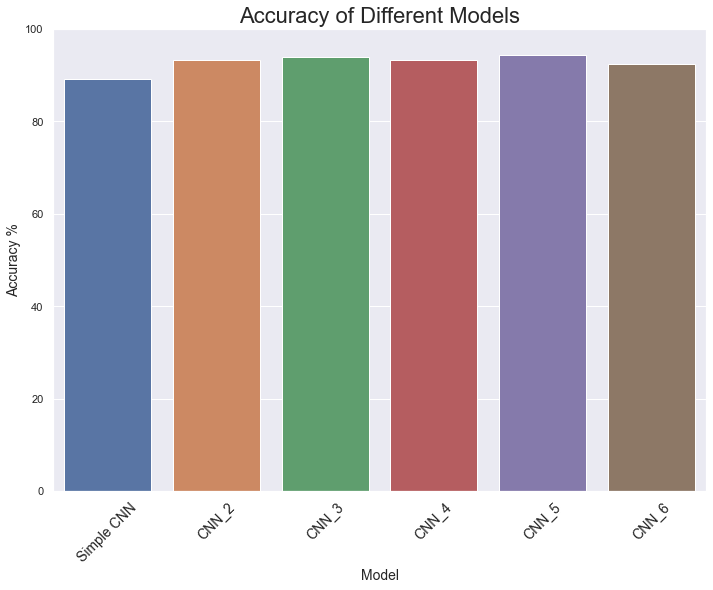

In [112]:
sns.set(rc={'figure.figsize':(11.7,8.5)})
sns.barplot(x = list(metrics_dict.keys()), y=val_accuracy_scores)

plt.ylim(0, 100)
plt.xticks(rotation='45', fontsize=14)
plt.title('Accuracy of Different Models', fontsize=22)
plt.ylabel('Accuracy %', fontsize=14)
plt.xlabel('Model', fontsize=14);
#plt.savefig('AccuracyBar.png', dpi=300)

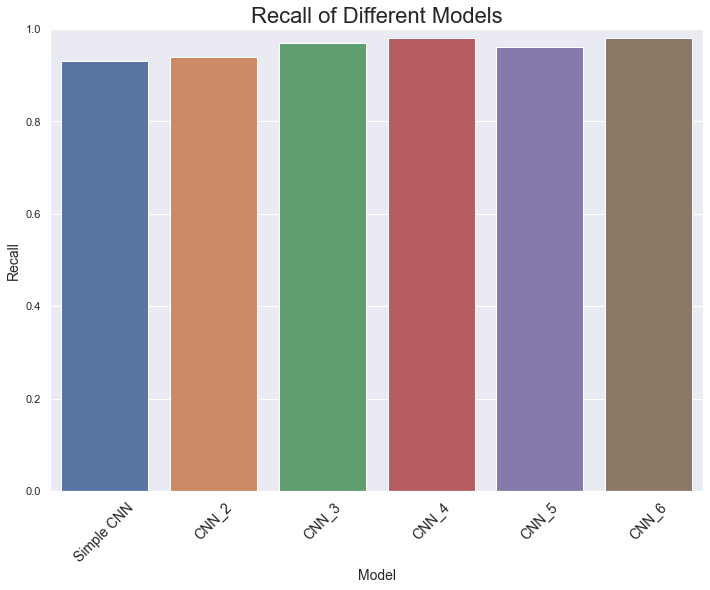

In [146]:
sns.set(rc={'figure.figsize':(11.7,8.5)})
sns.barplot(x = list(metrics_dict.keys()), y=val_recall_scores)

plt.ylim(0, 1)
plt.xticks(rotation='45', fontsize=14)
plt.title('Recall of Different Models', fontsize=22)
plt.ylabel('Recall', fontsize=14)
plt.xlabel('Model', fontsize=14);
#plt.savefig('RecallBar.png', dpi=300)

The two bar plots show our model's accuracy and recall scores on the validation data. The simple CNN model had the lowest metric scores which is good news since it means our iterative modeling process improved upon the simple CNN model. Accuracy for all models was similar, hovering above and below 93%. We believed that recall was a more important metric than accuracy. Recall is an indicator of false negative rates. Our focus with this modeling project is to provide a second opinion to doctors and ensure that no child with pneumonia is overlooked. It is more costly and dangerous if pneumonia-positive patients are overlooked and aren't able to receieve treatment quickly. The model is not meant to replace a doctor's diagnosis but rather provide a red flag so that a doctor can re-evaluate their initial diagnosis. When determining our best performing models, we wanted to pick out a model with a strong performance in recall. 

Therefore, we decided that CNN 6 is our strongest performing model. It has an accuracy of 92.3% and recall of 98.2% on the validation set. 

Now that we have a final model chosen, let's see its performance on the holdout test set.

In [193]:
test_set_metrics = cnn_6.evaluate(test_images, test_labels)
test_set_metrics

20/20 [==============================] - 0s 10ms/step - loss: 0.4669 - accuracy: 0.8606 - recall_19: 0.9821


[0.46690496802330017, 0.8605769276618958, 0.9820512533187866]

The final model has an accuracy of 86% and a recall of 0.98. The low accuracy (compared to train and validation scores) indicated that our model does not do a great job with unseen data, particularly not with this test set. However, the recall score was still strong despite the drop in accuracy. Overfitting was a persistent issue in our modeling process and the scores on the testing data show that future iterations on the model should focus on addressing this issue.

In [117]:
#importing a pickled model
cnn_6 = load_model('saved_models/cnn_6')

In [141]:
#getting predictions as probabilities from our final model on the test data
preds = cnn_6.predict(test_images)

In [142]:
#getting predicted labels from our prediction probabilities
pred_labels = np.where(preds >= 0.5, 1,0)

In [131]:
model_cm = confusion_matrix(test_labels, pred_labels)
model_cm

array([[154,  80],
       [  7, 383]], dtype=int64)

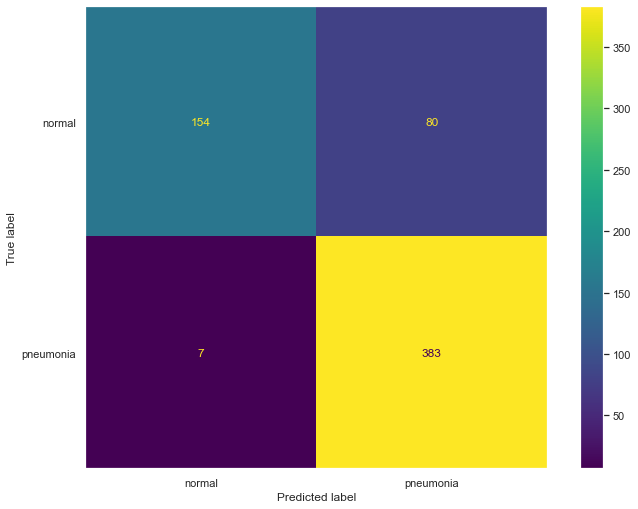

In [140]:
#plotting the Confusion Matrix of our final model's results on the test data
disp = ConfusionMatrixDisplay(model_cm, display_labels=['normal', 'pneumonia'])
disp.plot()
plt.grid(False);
#plt.savefig('ConfMat.png', dpi=300)

Our of 390 pneumonia cases in our test X-ray images, our model correctly identified 383 images and misclassified 7 images. Out of 234 normal cases in our test X-ray images, our model correctly identified 154 and misclassified 80 images. The final model met our goal of minimizing false negative cases with a false-negative rate of 1.8%. Overall accuracy of our model is hindered by its false-positive rate.  

If we were to continue to improve this model, our next steps would be to address overfitting and try increasing image resolution. We could try adding more regularization or dropout layers to hopefully improve this model's ability to predict on unseen data. Additionally, we could better train our model given more data or with higher quality data. Our model is trained on images of 64 x 64 resolution. Increasing resolution could provide more details for the model to learn from at the cost of computational cost. Our training data set consisted of 4,173 images. One way to better train our model is to provide more data to our model through further image augmentation or additional X-ray images. 

## Conclusion

The goal of this project was to construct a CNN model to classify chest X-rays of pediatric patients and identify which X-rays showed indicators of pneumonia. This model could be used as a "second opinion" for doctors with the intent of catching all penumonia-positive patients. Since childhood pneumonia can be deadly if not treated, we focused on a model with the lowest false-negative rate.

Our final model had an overall accuracy of 86% and a recall of 0.98. Overfitting was one of the major hurdles in our modeling process which we addressed but did not manage eliminate from our models. On unseen data, our model correctly diagnosed 98% of all pneumonia-labeled X-rays. This model met our goal of reducing false-negative rate while improving on accuracy over previous model iterations.

Next steps:
* Improve model with additional techniques to address overfitting
* Test model on images of different quality
* Identify if there are particular X-rays that doctors are consistently missing that a neural network might be able to assist with